# Twitter Pulse Checker

In [ ]:
# Importing the Libraries

import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [ ]:
access_token = "1033758126699364353-x3BuGV7xyqRDzFGavUH6OeCj0WpsUS"
access_secret = "sZWdviYTFuVENnNvcWEyk2G34pEcMt8zdkvGhblQcLSl4"
consumer_key = "NJjaAZwo1ebDZWHTuYFv7PobW"
consumer_secret = "QHQUEYmDoiBMqk0PitkUl2BxbAKp2XEsrVpvKtmgEYr4ZlXkph"

### Authenticate with Twitter API

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)


###Scraping Twitter Data!

In [ ]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = 'disaster' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 9000 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = True #@param {type:"boolean"}

tweetsPerQry = 5000  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="en")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
          
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 9088 tweets


Let's load the tweet data into a Pandas Dataframe so we can do Data Science to it. 

The data is also saved down in a tweets.csv file in case you want to download it.

In [ ]:
pd.set_option('display.max_colwidth', -1)

# load it into a pandas dataframe
dataset = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
dataset.to_csv('tweets.csv')
dataset.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-01-06,Disaster,1346940308181815299,get_bikes,President-Elect Dr. Rev. Dawn Scorched Earth Swamp,"@samanthamarika1 Ironically they just had someone on Fox News radio saying ""This is a disaster."" I turned it off.",0,0,0,False
1,2021-01-06,Disaster,1346940299818401794,lizzielixie,lizzie🍊,"I don’t really like talking about politics but what’s happening right now in the states is a disaster, everyone ple… https://t.co/RwECWnuViQ",0,0,0,False
2,2021-01-06,Disaster,1346940293296214019,Northborn_Sword,Northborn Sword🔞,"Thinking about how we all have some variation on that conversation four years ago when we told someone we knew, ""th… https://t.co/MitTya2Huv",0,0,0,False
3,2021-01-06,Disaster,1346940278578454529,cyberpunkonline,Cyberpunk Online,"The world doesn’t need hot-takes about the developing situation. Do something, actually really do something, or shu… https://t.co/9f0ge9ksEc",0,0,0,False
4,2021-01-06,Disaster,1346940259876143104,fletch_ai,fletch,5 ways to take control of data in 2021\n- Use AI to prevent data leaks &amp; protect #privacy\n- Prioritize identity and… https://t.co/dOc6zGzDvm,0,0,0,False


In [ ]:
print('Dataset size:',dataset.shape)
print('Columns are:',dataset.columns)

Dataset size: (9088, 10)
Columns are: Index(['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count',
       'reply_count', 'retweet_count', 'retweeted'],
      dtype='object')


In [ ]:
dataset.head(3)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-01-06,Disaster,1346940308181815299,get_bikes,President-Elect Dr. Rev. Dawn Scorched Earth Swamp,"@samanthamarika1 Ironically they just had someone on Fox News radio saying ""This is a disaster."" I turned it off.",0,0,0,False
1,2021-01-06,Disaster,1346940299818401794,lizzielixie,lizzie🍊,"I don’t really like talking about politics but what’s happening right now in the states is a disaster, everyone ple… https://t.co/RwECWnuViQ",0,0,0,False
2,2021-01-06,Disaster,1346940293296214019,Northborn_Sword,Northborn Sword🔞,"Thinking about how we all have some variation on that conversation four years ago when we told someone we knew, ""th… https://t.co/MitTya2Huv",0,0,0,False


In [ ]:
dataset.tweet.fillna('None', inplace=True) 

#############################################################################################################################
## Expand Contractions

# Function for expanding most common contractions https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

dataset.tweet = [decontraction(tweet) for tweet in dataset.tweet]

#############################################################################################################################
## Remove Emojis

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

print(remove_emoji("OMG there is a volcano eruption!!! 😭😱😷"))

dataset.tweet = dataset.tweet.apply(lambda x: remove_emoji(x))

OMG there is a volcano eruption!!! 


In [ ]:
############################################################################################################################
## Remove URLs
dataset.tweet = dataset.tweet.apply(lambda x: remove_url(x))

#############################################################################################################################
## Remove Punctuations except '!?'

def remove_punct(tweet):
    new_punct = re.sub('\ |\!|\?', '', punctuation)
    table=str.maketrans('','',new_punct)
    return text.translate(table)

dataset.text = dataset.tweet.apply(lambda x: remove_punct(x))

#############################################################################################################################
## Replace amp
def replace_amp(text):
    text = re.sub(r" amp ", " and ", tweet)
    return text

dataset.text = dataset.tweet.apply(lambda x: replace_amp(x))

#############################################################################################################################

NameError: ignored

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Get all the word tokens in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in dataset[dataset.target == 0].text for word in word_tokenize(tweet)]
corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in dataset[dataset.target == 1].text for word in word_tokenize(tweet)]

# Function for counting top stopwords in a corpus
def count_top_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop: 
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:10] # get the top 10 stopwords
    x,y = zip(*topwords) # get key and values
    return x,y

x0,y0 = count_top_stopwords(corpus0)
x1,y1 = count_top_stopwords(corpus1)

# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=color[0])
plt.title('Top Stopwords for Non-Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=color[1])
plt.title('Top Stopwords for  Disaster Tweets')

AttributeError: ignored

#Polarit of the Sentiment

In [ ]:
dataset['Sentiment'] = dataset['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

In [ ]:
dataset.head(3)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Sentiment
0,2021-01-06,Disaster,1346833173146193920,judeacuff,#TransparencyandTruth,@BrendanBuck 75 Million Votes clown for an Incumbent. What a disaster!,0,0,0,False,0.0
1,2021-01-06,Disaster,1346833168654077952,LADYBIR83225091,LADYBIRD,"@ColorsTV @RubiDilaik @VootSelect @BeingSalmanKhan Big boss makers are very manipulative, the moment they realise t… https://t.co/CixTdjlyCw",0,0,0,False,0.1
2,2021-01-06,Disaster,1346833160051462146,Badbiitchlauren,Dymitrie / Castrid is watching eah 🌥️,@disaster_top @nemosdad HELP,0,0,0,False,0.0


#Categorizing the Sentiments of the Tweets

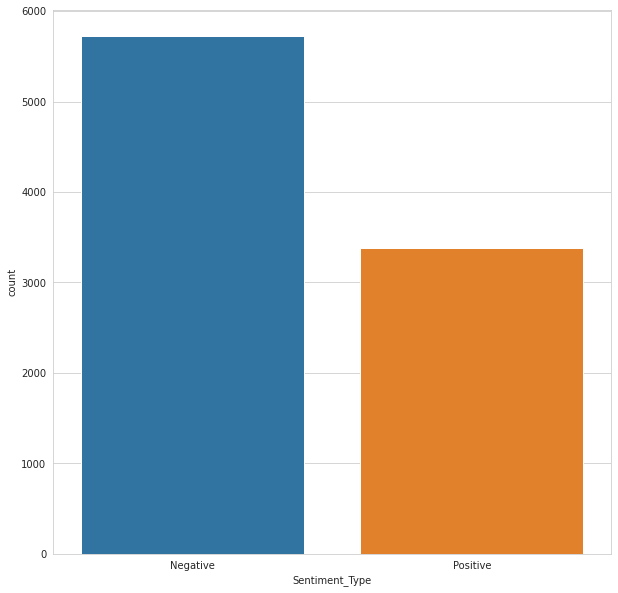

In [ ]:
from textblob import TextBlob

bloblist_title = list()

df_usa_title_str=dataset['tweet']
for row in df_usa_title_str:
    blob = TextBlob(row)
    bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_usa_polarity_title = pd.DataFrame(bloblist_title, columns = ['sentence','sentiment','polarity'])
 
def f_title(df_usa_polarity_title):
    if df_usa_polarity_title['sentiment'] > 0:
        val = "Positive"
    else:
        val = "Negative"
    return val

df_usa_polarity_title['Sentiment_Type'] = df_usa_polarity_title.apply(f_title, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_usa_polarity_title)

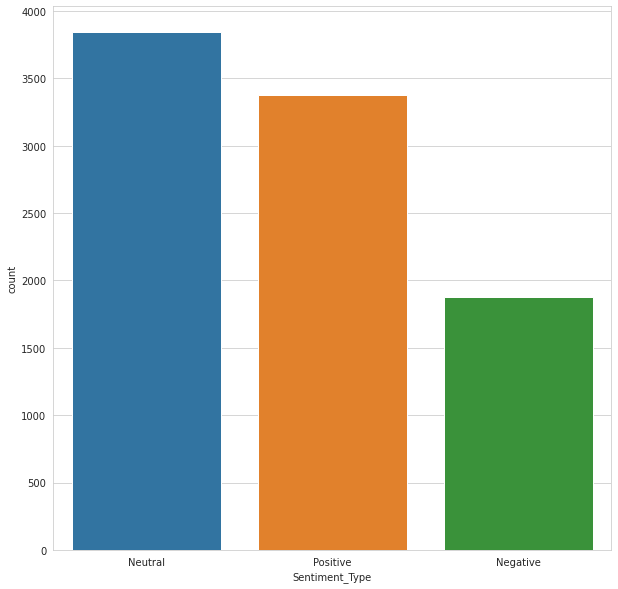

In [ ]:
from textblob import TextBlob

bloblist_title = list()

df_usa_title_str=dataset['tweet']
for row in df_usa_title_str:
    blob = TextBlob(row)
    bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_usa_polarity_title = pd.DataFrame(bloblist_title, columns = ['sentence','sentiment','polarity'])
 
def f_title(df_usa_polarity_title):
    if df_usa_polarity_title['sentiment'] > 0:
        val = "Positive"
    elif df_usa_polarity_title['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_usa_polarity_title['Sentiment_Type'] = df_usa_polarity_title.apply(f_title, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_usa_polarity_title)

#Detecting and Treating Missing Values

,Total,Percent
Sentiment,0,0.0
retweeted,0,0.0
retweet_count,0,0.0
reply_count,0,0.0
like_count,0,0.0


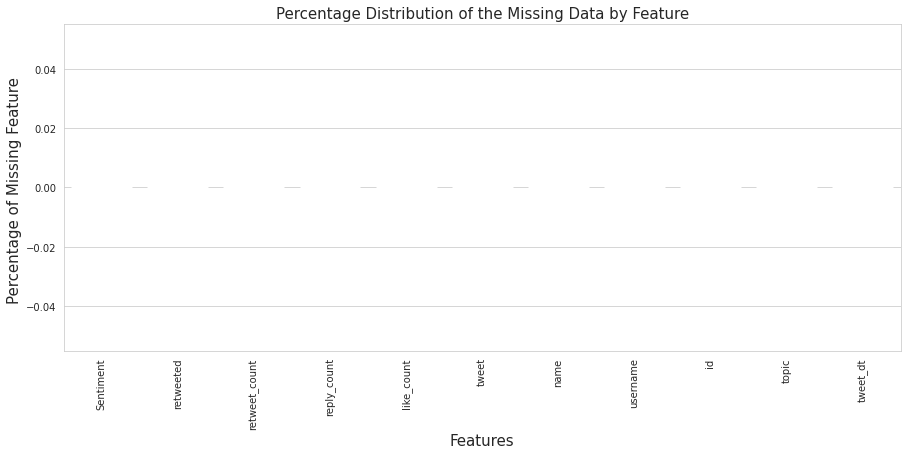

In [ ]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of Missing Feature ', fontsize=15)
plt.title('Percentage Distribution of the Missing Data by Feature', fontsize=15)
missing_data.head()

## Handling the Date Time

In [ ]:
from datetime import date
dataset['tweet_dt'] = pd.to_datetime(dataset['tweet_dt'])

In [ ]:
dataset['Year'] = dataset['tweet_dt'].dt.year
dataset['Week of the Year'] = dataset['tweet_dt'].dt.weekofyear
dataset['Day of the Year'] = dataset['tweet_dt'].dt.dayofyear
dataset['Month_name'] = dataset['tweet_dt'].dt.month_name()
dataset['Day of the Week'] = dataset['tweet_dt'].dt.weekday
dataset['Name of the Day'] = dataset['tweet_dt'].dt.day_name()
dataset['Hour'] = dataset['tweet_dt'].dt.hour
dataset['Minute'] = dataset['tweet_dt'].dt.minute

In [ ]:
dataset.head(3)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Sentiment,Year,Week of the Year,Day of the Year,Month_name,Day of the Week,Name of the Day,Hour,Minute
0,2021-01-06,Disaster,1346833173146193920,judeacuff,#TransparencyandTruth,@BrendanBuck 75 Million Votes clown for an Incumbent. What a disaster!,0,0,0,False,0.0,2021,1,6,January,2,Wednesday,0,0
1,2021-01-06,Disaster,1346833168654077952,LADYBIR83225091,LADYBIRD,"@ColorsTV @RubiDilaik @VootSelect @BeingSalmanKhan Big boss makers are very manipulative, the moment they realise t… https://t.co/CixTdjlyCw",0,0,0,False,0.1,2021,1,6,January,2,Wednesday,0,0
2,2021-01-06,Disaster,1346833160051462146,Badbiitchlauren,Dymitrie / Castrid is watching eah 🌥️,@disaster_top @nemosdad HELP,0,0,0,False,0.0,2021,1,6,January,2,Wednesday,0,0


#Quick Visualizations

Text(0.5, 1.0, 'Top 5 Active Tweeps')

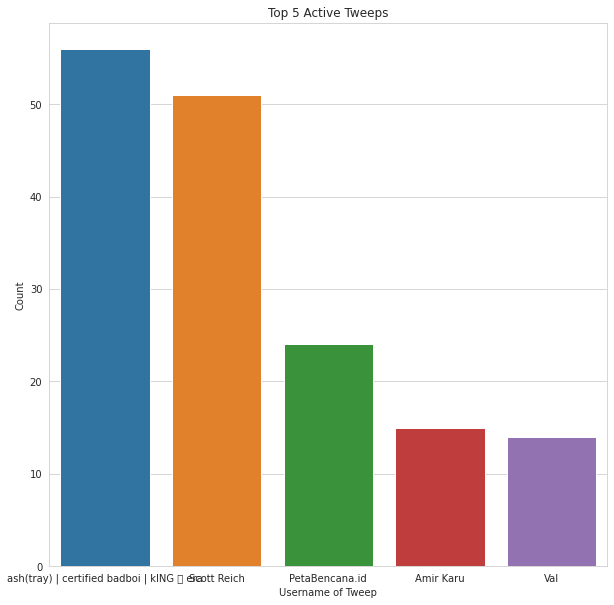

In [ ]:
trending_location=dataset.groupby(by=['name'],as_index=False).count().sort_values(by='tweet',ascending=False).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=trending_location['name'],y=trending_location['tweet'], data=trending_location)
plt.xlabel("Username of Tweep")
plt.ylabel("Count")
plt.title("Top 5 Active Tweeps")

**Top 5 Days of the Year Tweeps Tweeted on the top**

Text(0.5, 1.0, 'Top 5 Days of the Year Tweets were made')

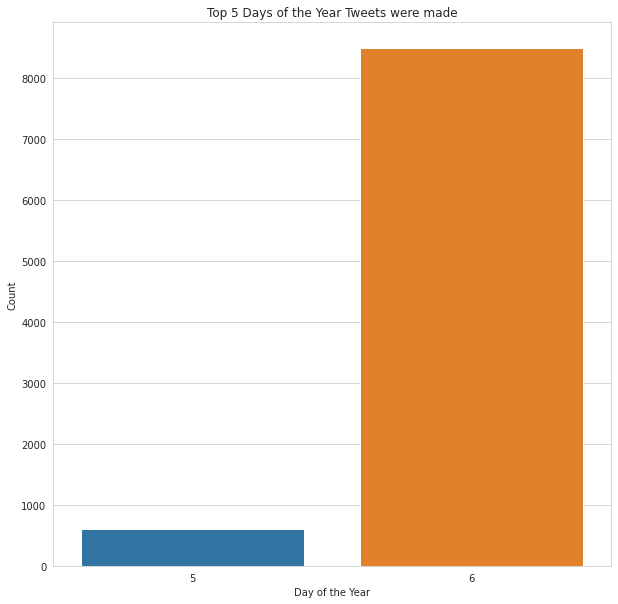

In [ ]:
day_of_the_week=dataset.groupby(by=['Day of the Year'],as_index=False).count().sort_values(by='Hour',ascending=False).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=day_of_the_week['Day of the Year'],y=day_of_the_week['Hour'], data=day_of_the_week)
plt.xlabel("Day of the Year")
plt.ylabel("Count")
plt.title("Top 5 Days of the Year Tweets were made")

Text(0.5, 1.0, 'Top 5 Days of the Year Tweeps Tweeted')

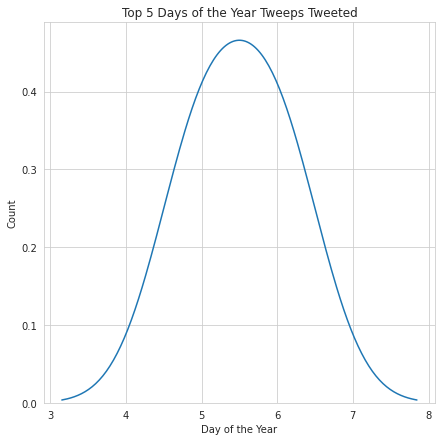

In [ ]:
Day_of_the_year=dataset.groupby(by=['Day of the Year'],as_index=False).count().sort_values(by='Hour',ascending=False).head(5)


plt.figure(figsize=(7,7))
sns.kdeplot(Day_of_the_year['Day of the Year']);
plt.xlabel("Day of the Year")
plt.ylabel("Count")
plt.title("Top 5 Days of the Year Tweeps Tweeted")

In [ ]:
from nltk.corpus import stopwords
from textblob import TextBlob
import numpy as np

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#) Understanding the impact of Hashtags on tweets sentiment

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(dataset['tweet'][dataset['Sentiment'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(dataset['tweet'][dataset['Sentiment'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

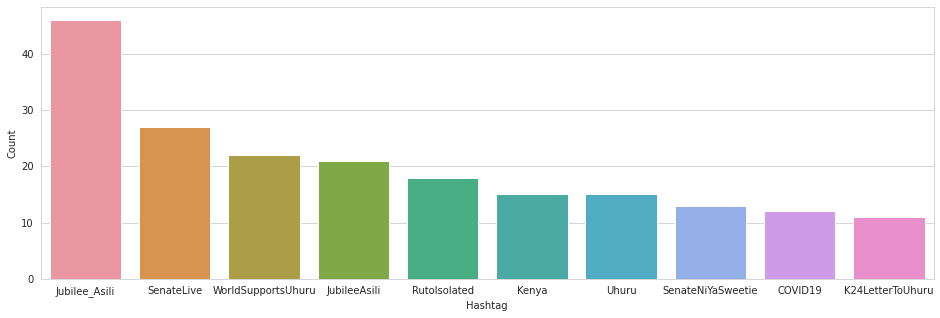

In [ ]:

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize # import word_tokenize

from nltk.corpus import stopwords #import stop words
import re # import regular expression
from nltk.tokenize import word_tokenize # import word_tokenize
from sklearn.utils import shuffle # to shuffle the data
import random # import random
import sklearn # import sklearn
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

In [ ]:
#Import Packages

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.tokenize import word_tokenize
import string
import seaborn as sns
from nltk.stem.porter import * 
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

dataset['tweet'] = dataset['tweet'].apply(lambda x: remove_punct(x))

In [ ]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

dataset['tweet'] = dataset['tweet'].apply(lambda x: tokenization(x.lower()))

In [ ]:

ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

dataset['tweet'] = dataset['tweet'].apply(lambda x: stemming(x))

In [ ]:
dataset.head(4)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Sentiment,Year,Week of the Year,Day of the Year,Month_name,Day of the Week,Name of the Day,Hour,Minute
0,2020-06-19,Uhuru,1274082560566591491,kenyan_digest,The Kenyan Digest,"[uhuru, name, hi, favorit, kenyanmad, beer, brand, httpstcovmkqijrwfk]",0,0,0,False,0.50,2020,25,171,June,4,Friday,0,0
1,2020-06-19,Uhuru,1274082464802189312,aketchdenis7,Aketch,"[gabrieloguda, let, uhuru, start, with, maguir, and, degea, dean, henderson, must, be, in, thi, team, come, next, season, dave, sh, httpstcovnkao]",0,0,0,False,0.00,2020,25,171,June,4,Friday,0,0
2,2020-06-19,Uhuru,1274082174464143361,wanjala_dennis,wanjala dennis,"[, uhuru, amp, e, beneficiari, of, hi, regim, have, run, a, relentless, campaign, against, hi, deputi, ruto, paint, him, as, httpstcoxrrxsec]",0,0,0,False,0.00,2020,25,171,June,4,Friday,0,0
3,2020-06-19,Uhuru,1274081632790740992,DolaEdward,Frank Dola,"[sirjimkitch, uhuru, ha, broken, mani, law, includ, break, the, law, ]",0,0,0,False,0.05,2020,25,171,June,4,Friday,0,0


In [ ]:

from nltk.stem import PorterStemmer
st = PorterStemmer()
dataset['tweet'][:10].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    uhuru name hi favorit kenyan-mad beer brand - https://t.co/vmkqijrwfk                                                                     
1    @gabrieloguda let uhuru start with maguir and degea. dean henderson must be in thi team come next season. dave sh… https://t.co/v08n7k03ao
2    20/ uhuru &amp; e' beneficiari of hi regim have run a relentless campaign against hi deputy, ruto, paint him as… https://t.co/xr40r9xsec  
3    @sirjimkitch uhuru ha broken mani law includ break the law😂😂😂                                                                             
4    doesn't these man unit chap know that kenya just won a seat at the secur council? they'r play as if we do… https://t.co/b81dplnp3a        
5    @andrewsoitana @kenyanheir @muriukieugen Do you actual realis that both ruto an ld uhuru form the current jubile govt?                    
6    @smithobonyo @kipmurkomen mighti odm? list achiev of odm. never won an election, never run for elect on i… https://t.co/jswxqzyzn  

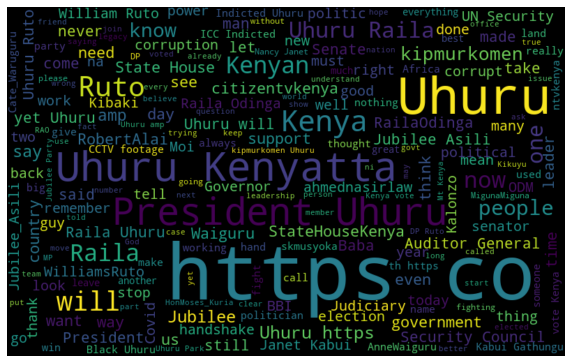

In [ ]:

# Creating word Cloud for all Words in all tweets
allWords = ' '.join([text for text in dataset['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [ ]:
import re
def clean_tweets(tweet):
    Tweet = re.sub("RT @[\w]*:","",tweet)
    Tweet = re.sub("@[\w]*","",tweet)
    Tweet = re.sub("https?://[A-Za-z0-9./]*","",tweet)
    Tweet = re.sub("\n","",tweet)
    return tweet

In [ ]:
dataset['tweet']=dataset['tweet'].apply(lambda x: clean_tweets(x))

In [ ]:
dataset.head(3)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Year,Week of the Year,Day of the Year,Month_name,Day of the Week,Name of the Day,Hour,Minute
0,2020-06-09,Waiguru,1270426477041979393,Jumabonny711,Juma7Bonny11✊,@KBonimtetezi Governor Ann Waiguru is the female DJ of the reggae in BBI. Take it to the bank that Baba Raila Oding… https://t.co/wC6WDoGbCx,0,0,0,False,2020,24,161,June,1,Tuesday,0,0
1,2020-06-09,Waiguru,1270426311723548673,Kamirara1,Kamirara,Can see reggae ya waiguru na raira has come to a silly stop. They may as well now resort to Nigeria dirges,0,0,0,False,2020,24,161,June,1,Tuesday,0,0
2,2020-06-09,Waiguru,1270426242601431043,Hillaknus,Hillary Kinuthia,The entire country Kenya is headed for closure.\n\nMutai\nKagame\nKericho\nWilly\nKirinyaga\nSenate\nWaiguru,0,0,0,False,2020,24,161,June,1,Tuesday,0,0


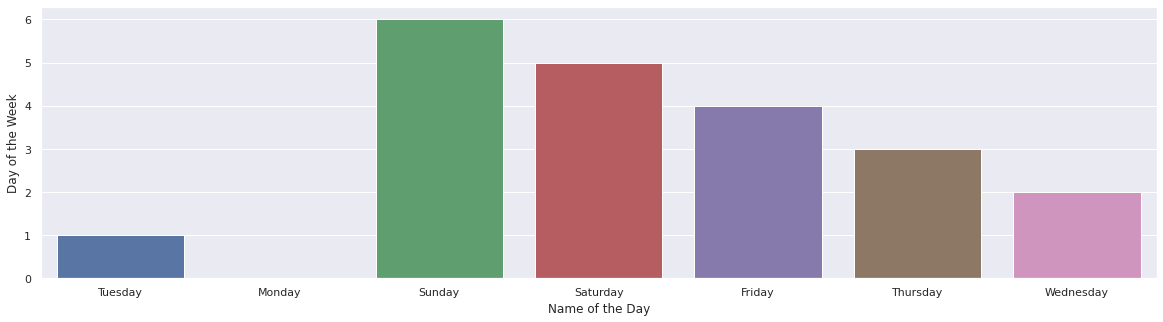

In [ ]:
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(x=dataset['Name of the Day'],y=dataset['Day of the Week']);

In [ ]:
dataset['Sentiment'] = dataset['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

In [ ]:
dataset.head(3)

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Year,Week of the Year,Day of the Year,Month_name,Day of the Week,Name of the Day,Hour,Minute,Sentiment
0,2020-06-09,Waiguru,1270426477041979393,Jumabonny711,Juma7Bonny11✊,@KBonimtetezi Governor Ann Waiguru is the female DJ of the reggae in BBI. Take it to the bank that Baba Raila Oding… https://t.co/wC6WDoGbCx,0,0,0,False,2020,24,161,June,1,Tuesday,0,0,0.0
1,2020-06-09,Waiguru,1270426311723548673,Kamirara1,Kamirara,Can see reggae ya waiguru na raira has come to a silly stop. They may as well now resort to Nigeria dirges,0,0,0,False,2020,24,161,June,1,Tuesday,0,0,-0.5
2,2020-06-09,Waiguru,1270426242601431043,Hillaknus,Hillary Kinuthia,The entire country Kenya is headed for closure.\n\nMutai\nKagame\nKericho\nWilly\nKirinyaga\nSenate\nWaiguru,0,0,0,False,2020,24,161,June,1,Tuesday,0,0,0.0


Text(0.5, 1.0, 'Top 5 Days of the Year Tweets were made')

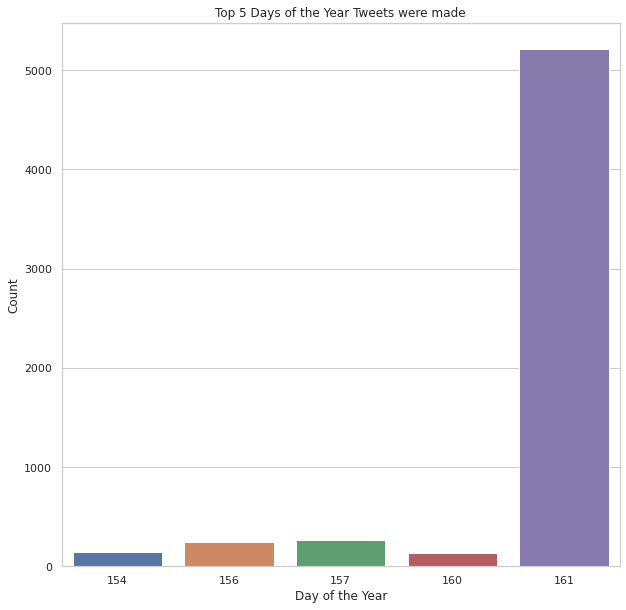

In [ ]:

day_of_the_week=dataset.groupby(by=['Day of the Year'],as_index=False).count().sort_values(by='Hour',ascending=False).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=day_of_the_week['Day of the Year'],y=day_of_the_week['Hour'], data=day_of_the_week)
plt.xlabel("Day of the Year")
plt.ylabel("Count")
plt.title("Top 5 Days of the Year Tweets were made")

Text(0.5, 1.0, 'Days of the Week Vs the Tweets tweeted per Day')

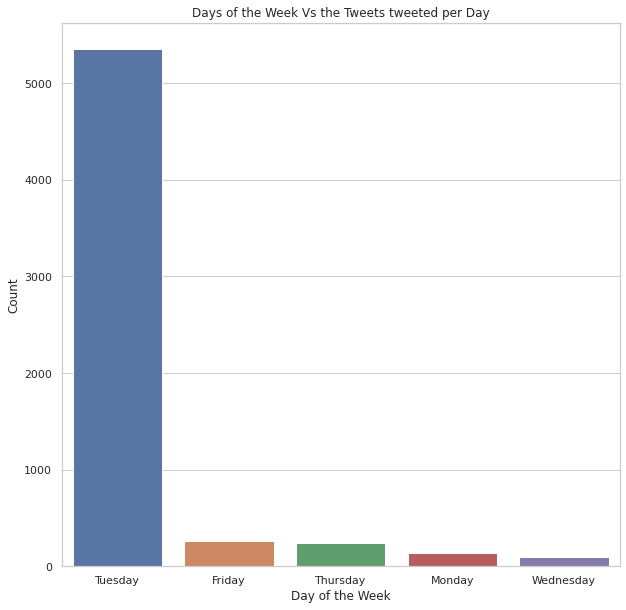

In [ ]:
day_of_the_week=dataset.groupby(by=['Name of the Day'],as_index=False).count().sort_values(by='tweet',ascending=False).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=day_of_the_week['Name of the Day'],y=day_of_the_week['tweet'], data=day_of_the_week)
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.title("Days of the Week Vs the Tweets tweeted per Day")

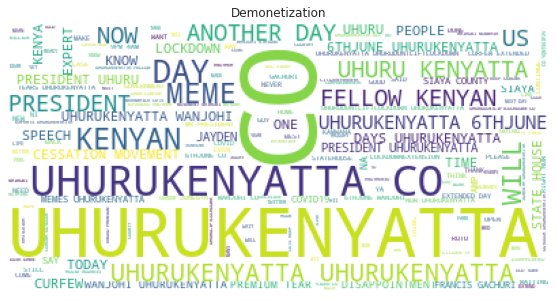

In [ ]:

def wordcloud_by_province(dataset):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    stopwords.add("demonetization")
    stopwords.add("Demonetization co")
    #Narendra Modi is the Prime minister of India
    stopwords.add("lakh")
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in dataset['tweet'].str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Demonetization")

wordcloud_by_province(dataset)

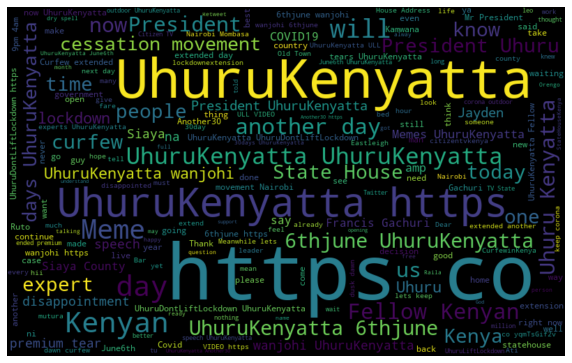

In [ ]:
# Creating word Cloud for all Words in all tweets
allWords = ' '.join([text for text in dataset['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [ ]:
#@title Filter By Date Range
today = datetime.now().date()
yesterday = today - timedelta(1)

start_dt = '' #@param {type:"date"}
end_dt = '' #@param {type:"date"}

if start_dt == '':
  start_dt = yesterday
else:
  start_dt = datetime.strptime(start_dt, '%Y-%m-%d').date()

if end_dt == '':
  end_dt = today
else:
  end_dt = datetime.strptime(end_dt, '%Y-%m-%d').date()


tweet_df = tweet_df[(tweet_df['tweet_dt'] >= start_dt) 
                    & (tweet_df['tweet_dt'] <= end_dt)]
tweet_df.shape

(1026, 10)

In [ ]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head()

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2019-06-21,Seattle,1141989410399051776,LarryJuneTFM,GOOD JOB LARRY 🍊,@grailfinders 🍊🍾 quick studio session in Seattle https://t.co/LiZ1PxMutG https://t.co/RH6TtLH9qZ,LOC,Seattle,POSITIVE,0.962521,0.962521,1,0,1
1,2019-06-21,Seattle,1141989396008308736,mtgdungeon00,wardon wiltsey,Not terrible for for getting donation goal 5 days before magic fest Seattle and having to put this together. Hope t… https://t.co/X3GgwVRbwE,ORG,Seattle,POSITIVE,0.910369,0.910369,0,0,0
2,2019-06-21,Seattle,1141989264760041473,seaveyjoycelyn,Joy•Why Dont We,@BeautyChickee I live near Seattle can we still be friends? I’m in need of a best friend,LOC,Seattle,POSITIVE,0.827820,0.827820,0,0,0
3,2019-06-21,Seattle,1141989048879210497,brando_tron,Brando,@fakemikemulloy Seattle one day my dude.,LOC,Seattle,POSITIVE,0.781143,0.781143,0,0,0
4,2019-06-21,Seattle,1141989011772366848,HubShare,Hubshare,That’s a wrap! Thank you to everyone who attended the Hubshare and SAI Systems Auditing Lunch &amp; Learn series! We he… https://t.co/v5pdkCl8ce,MISC,Hubshare,POSITIVE,0.997751,0.997751,0,0,0


Let's filter out obvious tags like #Seattle that would show up for this search. You can comment this portion out or use different Tags for your list.

In [ ]:
# filter out obvious tags
banned_words = ['Seattle', 'WA', '#Seattle', '#seattle', 'Washington', 'SEATTLE', 'WASHINGTON',
                'seattle', 'Seattle WA', 'seattle wa','Seattle, WA', 'Seattle WA USA', 
                'Seattle, Washington', 'Seattle Washington', 'Wa', 'wa', '#Wa',
               '#wa', '#washington', '#Washington', '#WA', '#PNW', '#pnw', '#northwest']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

In [ ]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,Seattle Jobs,ORG,16,0.877415,0,0,0
1,Mariners,ORG,11,0.920021,45,0,5
2,#sunset,Hashtag,11,0.961510,692,0,141
3,Seattle Mariners,ORG,10,0.811084,5,0,1
4,Orioles,ORG,8,0.954855,9,0,5


Create an overall Sentiment column based on the Average Polarity of the Tag.

In [ ]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,Seattle Jobs,ORG,16,0.877415,0,0,0,POSITIVE
1,Mariners,ORG,11,0.920021,45,0,5,POSITIVE
2,#sunset,Hashtag,11,0.961510,692,0,141,POSITIVE
3,Seattle Mariners,ORG,10,0.811084,5,0,1,POSITIVE
4,Orioles,ORG,8,0.954855,9,0,5,POSITIVE


## Visualize!

We can get some bar plots for the Tags based on the following metrics:



*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets

By default, we do the analysis on all the Tags but we can also filter by Tag by checking the Filter_TAG box. 
This way we can further drill down into the metrics for Hashtags, Persons, Locations & Organizations.

We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


Text(0.5, 0, '')

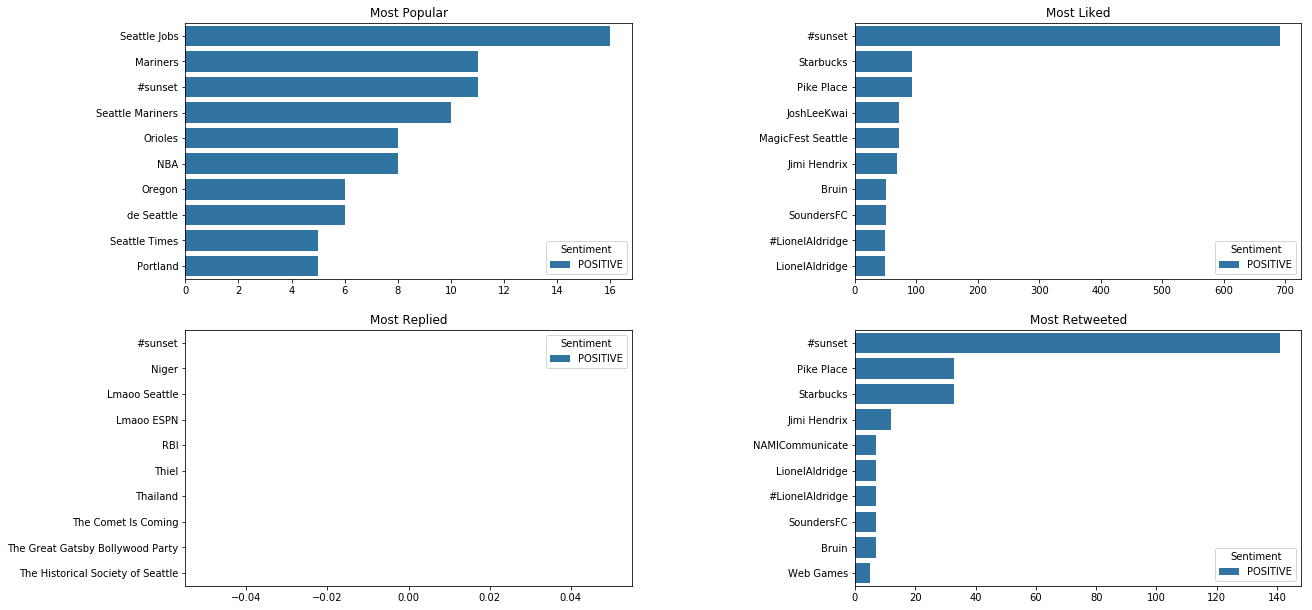

In [ ]:
#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Person' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

###Get the Average Polarity Distribution.

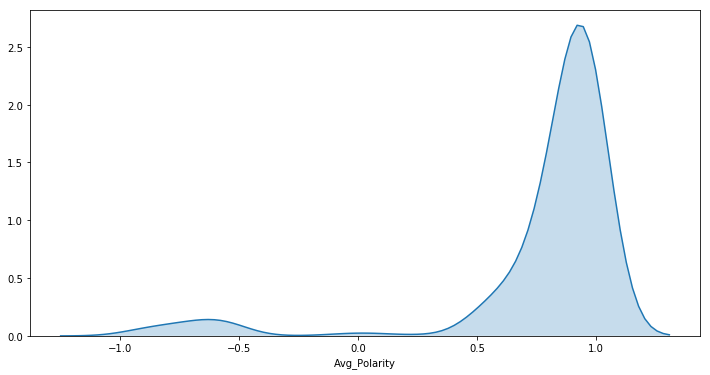

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in Seattle, I am going to use overlay the Seattle city skyline view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

Images for Masks can be found at:

http://clipart-library.com/clipart/2099977.htm

https://needpix.com

In [ ]:
# download mask images
!wget http://clipart-library.com/img/2099977.jpg -O seattle.jpg
!wget https://storage.needpix.com/rsynced_images/trotting-horse-silhouette.jpg -O horse.jpg
!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
clear_output()

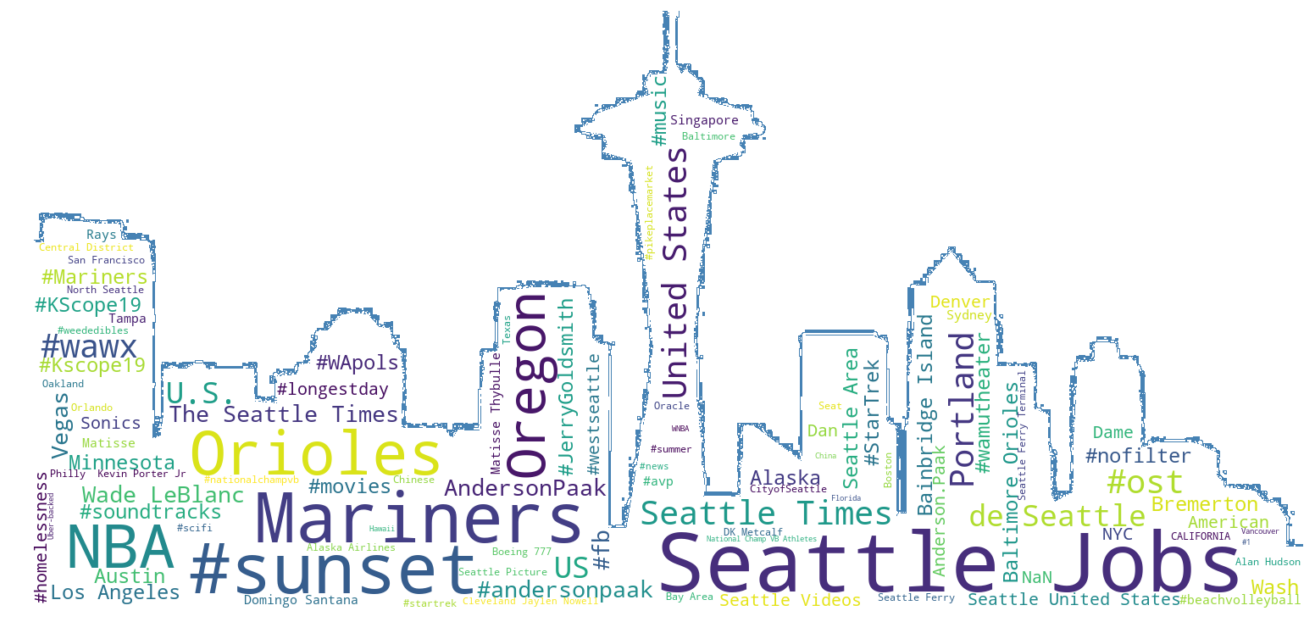

In [ ]:
#@title Build Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Location' #@param ["Hashtag", "Person", "Location", "Organization"]
Mask = 'Seattle' #@param ["Rectangle", "Seattle", "Balloon", "Horse"]

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  
if Mask == 'Seattle':
  Mask = np.array(Image.open("seattle.jpg"))
elif Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))
elif Mask == 'Horse':
  Mask = np.array(Image.open("horse.png"))
elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()